# Discover and mosaic Sentinel-2 tiles

In [ ]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import folium
import folium.plugins
import logging
from eo_tools.util import explore_products
from eo_tools.S2 import process_s2_tiles, make_s2_color
import rioxarray as riox


from eodag import EODataAccessGateway

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
logging.basicConfig(level=logging.INFO)

# Directory setup

In [ ]:
# change to your data directories
path_data = "/data"
path_s2 = f"{path_data}/S2"
path_processed = f"{path_data}/res"

# Search

In [ ]:
# load a geometry
file_aoi = "../data/Bretagne_AOI.geojson"
shp = gpd.read_file(file_aoi).geometry[0]
search_criteria = {
    "productType": "S2_MSI_L1C",
    "start": "2023-06-01",
    "end": "2023-08-31",
    "cloudCover": 10,
    "geom": shp
}
results = dag.search_all(**search_criteria)

Getting unique dates to help with product exploration

In [ ]:
def get_unique_dates(results):
    import numpy as np

    dates = []
    for p in results:
        dates.append(p.properties["startTimeFromAscendingNode"])
    return np.unique(dates).tolist()

dates = get_unique_dates(results)
print(f"unique dates:")
print(", \n".join(dates))

# Visualize product footprints on a map

In [ ]:
# show all results
# explore_products(results, shp)

# filter by date
results_filtered = results.filter_date("2023-06-05", "2023-06-06") 
explore_products(results_filtered, shp)

# Download

In [ ]:
# re-run to get only links
dl = dag.download_all(results_filtered, output_dir=path_s2)

# Merge downloaded tiles

In [ ]:
out_dirs = process_s2_tiles(
    dl,
    bands=["B2", "B3", "B4", "B8"],
    shp=shp,
    aoi_name="aoi_bretagne",
    output_dir=path_processed,
)

# Make CIR color composite

In [ ]:
make_s2_color(out_dirs[0], name="CIR")

# Visualize

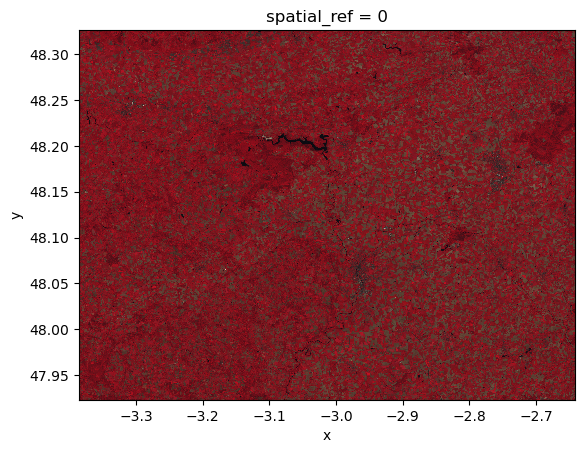

In [17]:
pth_arr = f"{out_dirs[0]}/CIR.tif"
arr = riox.open_rasterio(pth_arr)
arr.plot.imshow(cmap="gray", vmax=200)